# Flag hits likely due to differences in cell count

In [2]:
# Imports
import polars as pl
from tqdm import tqdm
import statsmodels.formula.api as smf

In [2]:
# Paths
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent_updatedmeta"
prof_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles"
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")
metrics_wtvar = pl.read_csv(f"{metrics_dir}/metrics_summary.csv")
min_class_num = 2

In [3]:
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

# Alleles must be mislocalized in both batches
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("Mislocalized")
).unique()

local_wtvar = local_wtvar.pivot(
    index=["allele_0", "Allele_set"],
    columns="Batch",
    values="Mislocalized",
).with_columns(
    ((pl.col("batch7") == 1) & (pl.col("batch8") == 1)).alias(
        "Mislocalized_both_batches"
    )
)

misloc_alleles = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)

misloc_wt = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .with_columns(pl.col("allele_0").str.replace("_.*", "").alias("wt"))
    .select("wt")
    .to_series()
    .unique()
    .to_list()
)

all_alleles = misloc_alleles + misloc_wt

In [4]:
# Get individual classifiers
ind_class = metrics_df.filter(
    (~pl.col("Metadata_Control"))
    & (
        pl.col("allele_0").is_in(misloc_alleles)
        & (pl.col("Full_Classifier_ID").str.contains("true"))
    )
)

In [5]:
# Get meta features
b7_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .select([
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)
b8_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .select([
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

profiles = pl.concat([b7_alleles.collect(), b8_alleles.collect()]).group_by([
    "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
]).count().rename({"count": "Cell_count"})

/tmp/ipykernel_21838/2572039596.py:25: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  profiles = pl.concat([b7_alleles.collect(), b8_alleles.collect()]).group_by([


In [6]:
def lmm(fix_var: str, rand_var: str, reference: str, var: str, dat):
    # perform stat test
    model = smf.mixedlm(
        f"{fix_var} ~ C(Metadata_gene_allele, Treatment(reference='{reference}'))",
        data=dat,
        groups=dat[rand_var],
    )
    result = model.fit()

    # format results
    summary_df = pl.DataFrame(result.summary().tables[1][1:2])
    summary_df = summary_df.with_columns([
        pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns
    ])

    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )

    return summary_df

In [7]:
well_cc_stats = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    well_cc_stats.append(
        lmm(
            "Cell_count",
            "Metadata_Plate",
            allele.split("_")[0],
            allele,
            temp_prof.to_pandas(),
        )
    )

well_cc_stats = pl.concat(well_cc_stats, how="vertical")
well_cc_stats = well_cc_stats.rename({"z": "cc_Z"})


  5%|▍         | 23/471 [00:01<00:18, 24.61it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
 69%|██████▉   | 324/471 [00:12<00:06, 24.49it/s]/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

In [12]:
well_cc_stats.columns

['Coef.', 'Std.Err.', 'cc_Z', 'P>|z|', '[0.025', '0.975]', 'Gene', 'Variant']

In [15]:
# Correct p-values
from statsmodels.stats.multitest import multipletests

corrected = multipletests(well_cc_stats["P>|z|"].to_numpy(), method="fdr_bh")[1]
well_cc_stats = well_cc_stats.with_columns(pl.Series("FDR", corrected))

In [16]:
# Write out results
well_cc_stats.write_csv("../results/well_cc_changes.csv")

In [18]:
# Total number of increase vs. decrease
total = well_cc_stats.shape[0]
per_dec = well_cc_stats.filter(pl.col("cc_Z") < 0).shape[0]/total
per_inc = well_cc_stats.filter(pl.col("cc_Z") > 0).shape[0]/total

print("total increasing vs. decreasing percent")
print(per_dec)
print(per_inc)

dec_sig = well_cc_stats.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_Z") < 0).shape[0]
inc_sig = well_cc_stats.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_Z") > 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

total increasing vs. decreasing percent
0.5583864118895966
0.4394904458598726
Number sig decreases
103
Number sig increases
58


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


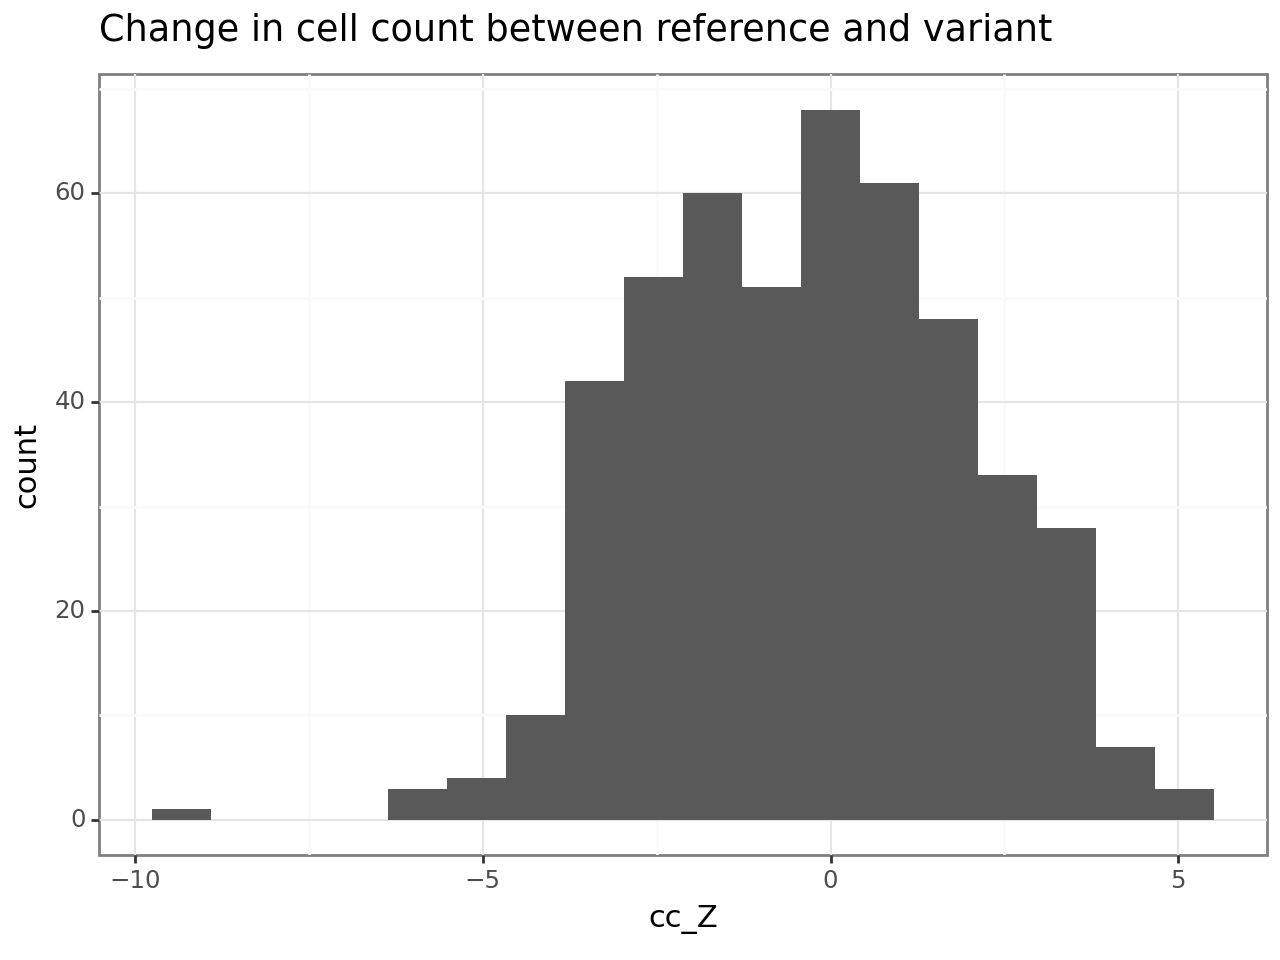

In [11]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs

plot1 = (
    ggplot(
        well_cc_stats,
        aes(x="cc_Z"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in cell count between reference and variant")
)
print(plot1)

## Analyze wrt Clinvar Annotations

In [3]:
cc_stats = pl.read_csv("../results/well_cc_changes.csv")

clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
).select(["Variant", "clinvar_cs"]).with_columns(
    pl.when(pl.col("clinvar_cs").is_not_null()).then("clinvar_cs").otherwise(pl.lit("not provided")).alias("clinvar_cs")
)

cc_stats = cc_stats.join(clinvar, on="Variant")

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


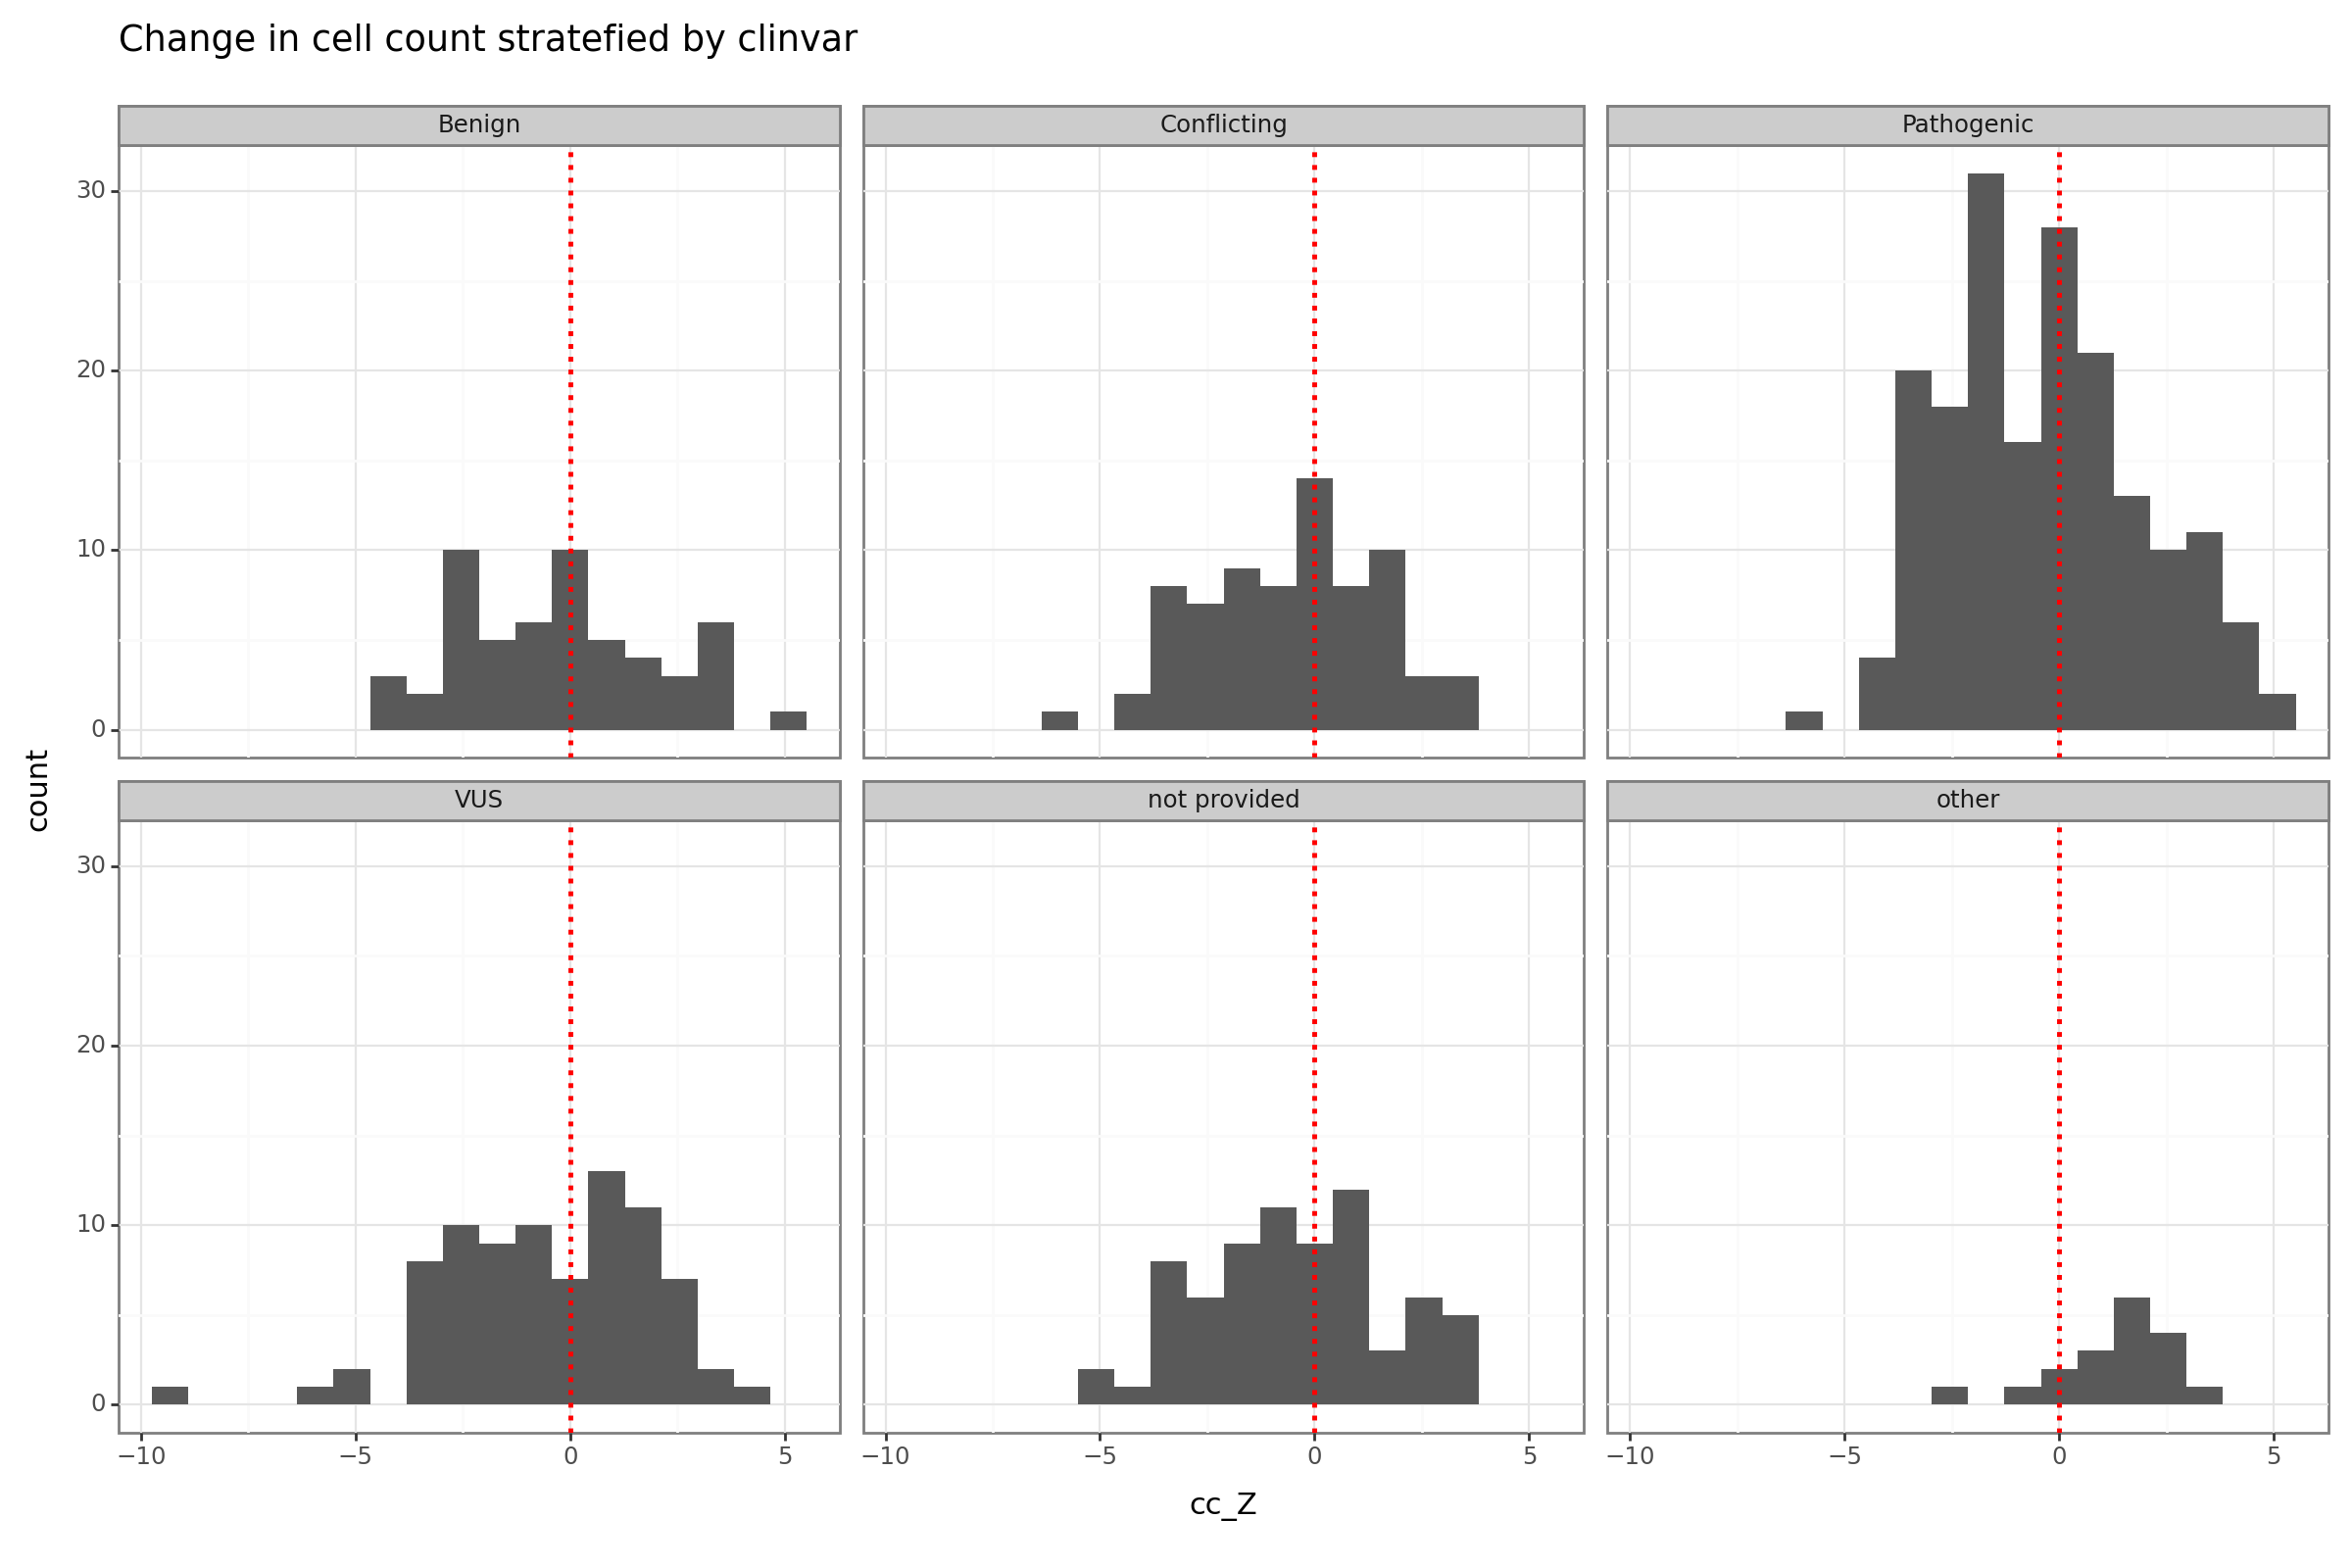

In [6]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs, facet_wrap, geom_vline
import plotnine as plotnine

plotnine.options.figure_size = (12, 8)
plot1 = (
    ggplot(
        cc_stats,
        aes(x="cc_Z"),
    )
    + geom_histogram()
    + facet_wrap("clinvar_cs")
    + geom_vline(xintercept=0, color="red", linetype="dotted", size=1)
    + theme_bw()
    + labs(title="Change in cell count stratefied by clinvar")
)
print(plot1)